In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from matplotlib import cm
import matplotlib.image as mpimg
%matplotlib inline
import scipy.optimize
import numpy as np

In [2]:
def read_data(path):
    """There are several csv files in path that get combined."""
    import os
    dfs = []
    for file in os.listdir(path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(path, file), sep=';')
            df['File'] = file
            dfs.append(df)
    return pd.concat(dfs), dfs


def get_filename(file):
    return file['x-position'][0]


data, files = read_data('data/characterisation_Li,32,poly3/SM315/0/20131028/Li,32,64,64,poly3')
files = sorted(files, key=get_filename)

colors = plt.get_cmap('Vega20b')

In [3]:
def polynomial2(x, p1, p2, p3):
    return p1 + p2 * x + p3 * x**2


def fit_polynomials(df):
    fits = []
    for date in ('x-position', 'left-position', 'right-position'):
        popt, pcov = scipy.optimize.curve_fit(polynomial2,
                                              df['y-position'],
                                              df[date],
                                              p0=(df[date][0], 0, 0)
                                             )
        fits.append(popt)
        df[date + '0'] = polynomial2(0, *popt)
    return fits


for file in files:
    file.popts = fit_polynomials(file)

In [4]:
dfs = []
for file in files:
    dfs.append(file)
data = pd.concat(dfs)

data_x1 = []
data_x2 = []
data_y = []
for date in ('x-position', 'left-position', 'right-position'):
    for x1, x2, y in zip(data['y-position'], data[date + '0'], data[date]):
        data_x1.append(x1)
        data_x2.append(x2)
        data_y.append(y)

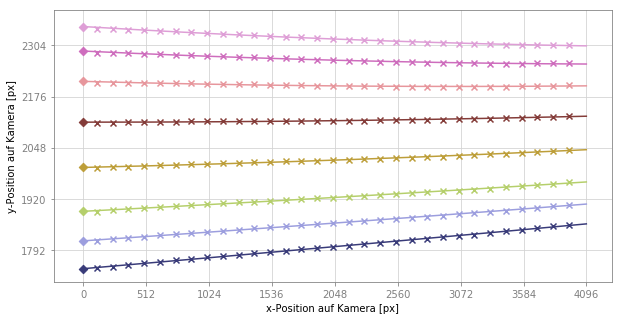

In [5]:
plt.figure(figsize=(10,5))
for j, file in enumerate(files):
    for i, date in enumerate(('x-position',)):
        plt.scatter(file['y-position'][1::4], file[date][1::4], c=colors(3*j+i), marker='x', linewidths=0.2)
        x_fit = np.linspace(0, 4095, 1000)
        y_fit = polynomial2(x_fit, *file.popts[i])
        plt.plot(x_fit, y_fit, c=colors(3*j+i))
        for val in set(file[date + '0']):
            plt.scatter(0, val, c=colors(3*j+i), marker='D', zorder=10)
plt.xticks(range(0, 4097, 512))
plt.xlabel('x-Position auf Kamera [px]')
plt.yticks(range(1792, 2305, 128))
plt.ylabel('y-Position auf Kamera [px]')
plt.show()

In [6]:
files[0].head()

,y-position,y-error,x-position,x-error,left-position,left-error,right-position,right-error,width,width-error,threshold,fitted-x-position,fitted-left-position,fitted-right-position,File,x-position0,left-position0,right-position0
0,79.864525,0.0,1745.424805,0.0,1649.0,0.0,1846.0,0.0,197.0,0.0,0.0,1745.576504,1649.134557,1845.483233,Cal_01.csv,1746.113752,1649.395823,1846.599838
1,111.863129,0.0,1746.579102,0.0,1650.0,0.0,1847.0,0.0,197.0,0.0,0.0,1746.683017,1650.493386,1846.354058,Cal_01.csv,1746.113752,1649.395823,1846.599838
2,143.868011,0.0,1747.663208,0.0,1652.0,0.0,1844.0,0.0,192.0,0.0,0.0,1747.779571,1651.841122,1847.215146,Cal_01.csv,1746.113752,1649.395823,1846.599838
3,175.868134,0.0,1748.787964,0.0,1653.0,0.0,1848.0,0.0,195.0,0.0,0.0,1748.865963,1653.177495,1848.066374,Cal_01.csv,1746.113752,1649.395823,1846.599838
4,207.870773,0.0,1749.864868,0.0,1654.0,0.0,1849.0,0.0,195.0,0.0,0.0,1749.942616,1654.503002,1848.908111,Cal_01.csv,1746.113752,1649.395823,1846.599838


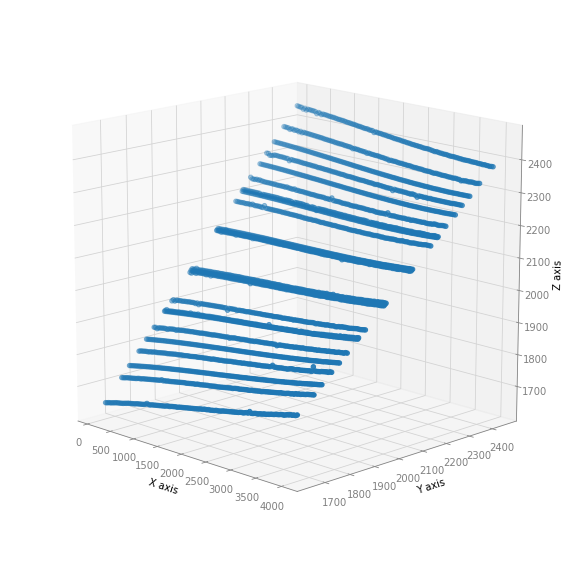

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection = '3d')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

ax.scatter(data_x1, data_x2, data_y)
ax.view_init(elev=15, azim=-45)
plt.show()

In [8]:
from numpy.polynomial import polynomial

# Mit (2, 3) funktioniert der Fit nicht gut genug.
# In meiner Java-Implementierung besteht dieses Problem nicht.
deg = (2, 2)

def polyfit2d(x, y, f, deg):
    ''' siehe http://stackoverflow.com/questions/7997152/python-3d-polynomial-surface-fit-order-dependent
    '''
    x = np.asarray(x)
    y = np.asarray(y)
    f = np.asarray(f)
    deg = np.asarray(deg)
    vander = polynomial.polyvander2d(x, y, deg)
    #vander = vander.reshape((-1,vander.shape[-1]))
    #f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

popt = polyfit2d(data_x1, data_x2, data_y, deg)
popt

array([[ -6.53200512e-03,   1.00000628e+00,  -8.47014784e-10],
       [  1.56635981e-01,  -7.59461675e-05,   6.97314297e-10],
       [ -2.85581000e-06,   1.59030408e-09,   1.21236354e-13]])

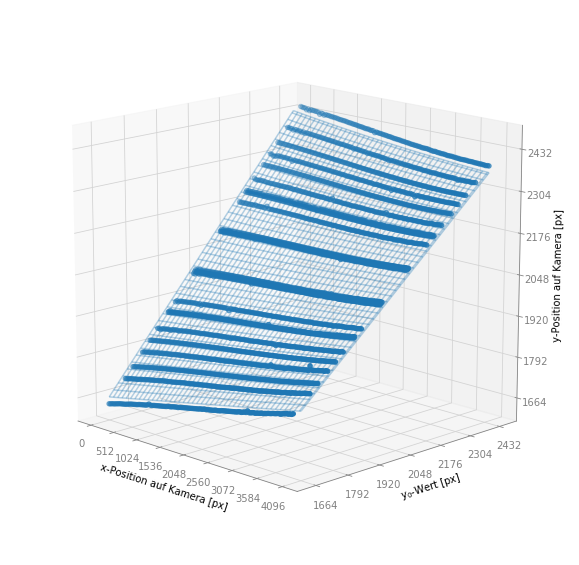

In [9]:
xs = np.linspace(0, 4097, 128)
ys = np.linspace(1792-128, 2305+128, 128)
Xs, Ys = np.meshgrid(xs, ys)
Zs = polynomial.polyval2d(Xs, Ys, popt)


fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection = '3d')

ax.set_xlabel('x-Position auf Kamera [px]')
ax.set_xticks(range(0, 4097, 512))
ax.set_ylabel('y$_0$-Wert [px]')
ax.set_yticks(range(1792-128, 2305+128, 128))
ax.set_zlabel('y-Position auf Kamera [px]')
ax.set_zticks(range(1792-128, 2305+128, 128))

ax.plot_wireframe(Xs, Ys, Zs, alpha=0.33)
ax.scatter(data_x1, data_x2, data_y)
ax.view_init(elev=15, azim=-45)
plt.show()

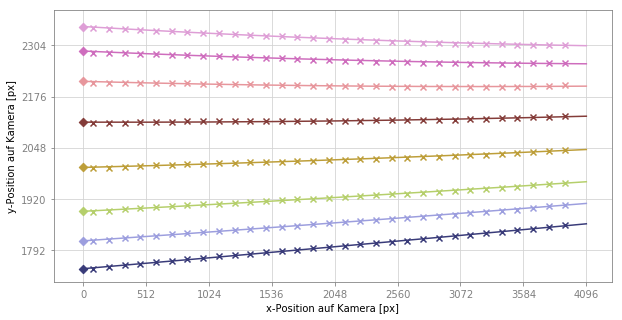

In [10]:
plt.figure(figsize=(10,5))
for j, file in enumerate(files):
    for i, date in enumerate(('x-position',)):
        plt.scatter(file['y-position'][0::4], file[date][0::4], c=colors(3*j+i), marker='x', linewidths=0.2)
        x_fit = np.linspace(0, 4097, 1000)
        y_fit = polynomial.polyval2d(x_fit, file[date + '0'][0], popt)
        plt.plot(x_fit, y_fit, c=colors(3*j+i))
        for val in set(file[date + '0']):
            plt.scatter(0, val, c=colors(3*j+i), marker='D', zorder=10)
plt.xticks(range(0, 4097, 512))
plt.xlabel('x-Position auf Kamera [px]')
plt.yticks(range(1792, 2305, 128))
plt.ylabel('y-Position auf Kamera [px]')
plt.show()

In [11]:
width_x1 = data['y-position']
width_x2 = data['x-position']
width_y = data['width']

deg_w = (2, 3)

popt_w = polyfit2d(width_x1, width_x2, width_y, deg_w)

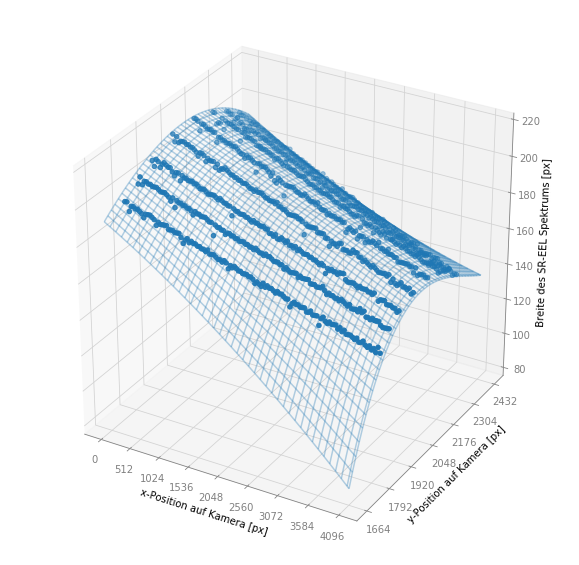

In [12]:
width_xs = np.linspace(0, 4097, 128)
width_ys = np.linspace(1792-128, 2305+128, 128)
width_Xs, width_Ys = np.meshgrid(width_xs, width_ys)
width_Zs = polynomial.polyval2d(width_Xs, width_Ys, popt_w)


fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection = '3d')

ax.set_xlabel('x-Position auf Kamera [px]')
ax.set_xticks(range(0, 4097, 512))
ax.set_ylabel('y-Position auf Kamera [px]')
ax.set_yticks(range(1792-128, 2305+128, 128))
ax.set_zlabel('Breite des SR-EEL Spektrums [px]')
#ax.set_zticks(range(0, 201, 25))

ax.plot_wireframe(width_Xs, width_Ys, width_Zs, alpha=0.33)
ax.scatter(width_x1, width_x2, width_y)
#ax.view_init(azim=15)
plt.show()

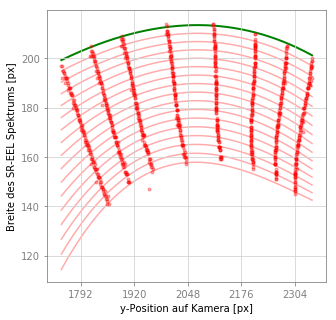

In [13]:
plt.figure(figsize=(5,5))
width_x = np.linspace(np.min(width_x2), np.max(width_x2), 1000)
width_0 = polynomial.polyval2d((0,)*1000, width_x, popt_w)
plt.plot(width_x, width_0, c='g', lw=2, zorder=-1)
step = 256
for i in range(step, 4097, step):
    width_i = polynomial.polyval2d((i,)*1000, width_x, popt_w)
    plt.plot(width_x, width_i, c='r', alpha=0.33, zorder=-2)
plt.scatter(width_x2, width_y, marker='.', c='r', alpha=0.33)
plt.xlabel('y-Position auf Kamera [px]')
plt.xticks(range(1792, 2305, 128))
plt.ylabel('Breite des SR-EEL Spektrums [px]')
plt.show()